In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device {device}')

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
import dolfin as dlf
dlf.set_log_level(40)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device cpu


## Poisson problem

INFO:train_pbnn:Building a TorchPBNN
INFO:train_pbnn:Loading model weights from ../models/Poisson/TorchLatentNet/model_weight.ckpt
INFO:train_pbnn:Model reached loss=0.0115 at epoch 199
INFO:train_pbnn:Loading dataset from ../data/poisson_dataset.hdf5
100%|██████████| 256/256 [00:00<00:00, 9452.37it/s]
INFO:train_pbnn:Train dataset length: 205
INFO:train_pbnn:Val dataset length: 51


Loss with ground truth force: 1.26e-15
Loss with assigned force: 0.0067


(0.0, 1.0, 0.0, 1.0)

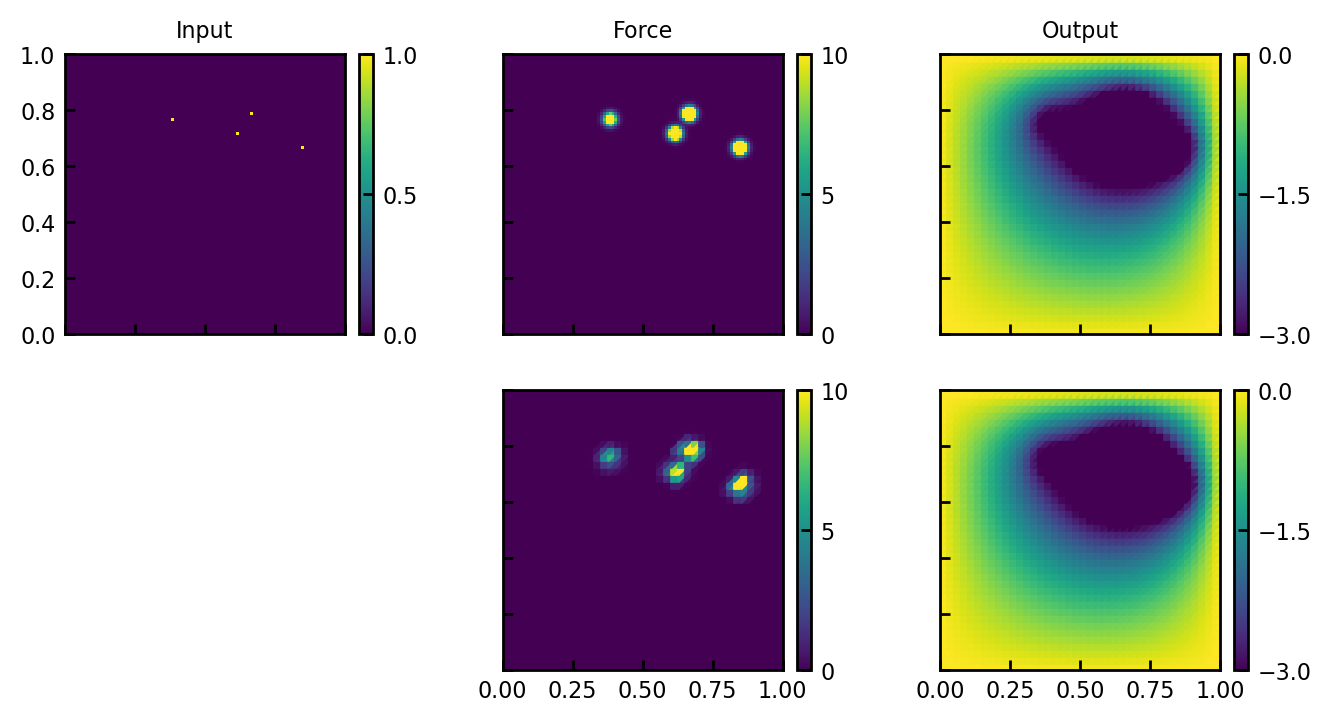

In [27]:
from train_pbnn import get_model, get_dataset
from mesh_utils import *
from plot_utils import *
import yaml
from pprint import pprint

import torch

with open('../models/Poisson/TorchLatentNet/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['dataset']['reduced_functional'] = True

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
dataset = val.dataset
model.eval()
model.to(device);

d_ad.set_working_tape(d_ad.Tape())

sample = val[0]
inputs = sample['inputs']
force = sample['force']
output = sample['output']
force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], sample['function_space'], return_function=True)
print(f'Loss with ground truth force: {sample['Jhat'](force_mesh.vector()[:]):.3g}')

fig, ax = plt.subplots(2, 3, figsize=(8,4), sharex=True, sharey=True, squeeze=False)

plot_grid(ax[0, 0], inputs[2], inputs[0], inputs[1])
plot_grid(ax[0, 1], force[0],  inputs[0], inputs[1], vmin=0, vmax=10)
plot_mesh(ax[0, 2], sample['output'], val.dataset.mesh, vmin=-3, vmax=0)

# Generate predictions
with torch.no_grad():
    force = model(torch.FloatTensor(inputs).to(device)).detach().cpu().numpy()

    force_mesh = multichannel_img_to_dofs(force, inputs[0], inputs[1], sample['function_space'], return_function=True)
    pred = val.dataset.build_problem.forward(force_mesh)

    print(f'Loss with assigned force: {sample['Jhat'](force_mesh.vector()[:]):.3g}')

    force = force_mesh.compute_vertex_values()
    pred = pred.compute_vertex_values()

# Generate and plot model predictions
plot_mesh(ax[1, 1], force, val.dataset.mesh, vmin=0, vmax=10)
plot_mesh(ax[1, 2], pred, val.dataset.mesh, vmin=-3, vmax=0)

ax[0,0].set_title('Input')
ax[0,1].set_title('Force')
ax[0,2].set_title('Output')

ax[1,0].axis('off')

## Stokes problem

INFO:train_pbnn:Building a TorchPBNN
INFO:train_pbnn:Loading model weights from ../models/Stokes/TorchLatentNet/model_weight.ckpt
INFO:train_pbnn:Model reached loss=4.19e-05 at epoch 198
INFO:train_pbnn:Loading dataset from ../data/stokes_dataset.hdf5
100%|██████████| 256/256 [00:00<00:00, 9312.67it/s]
INFO:train_pbnn:Train dataset length: 205
INFO:train_pbnn:Val dataset length: 51


Loss with assigned force: 7.67e-05
Loss with ground truth force: 1.81e-06


(0.0, 1.0, 0.0, 1.0)

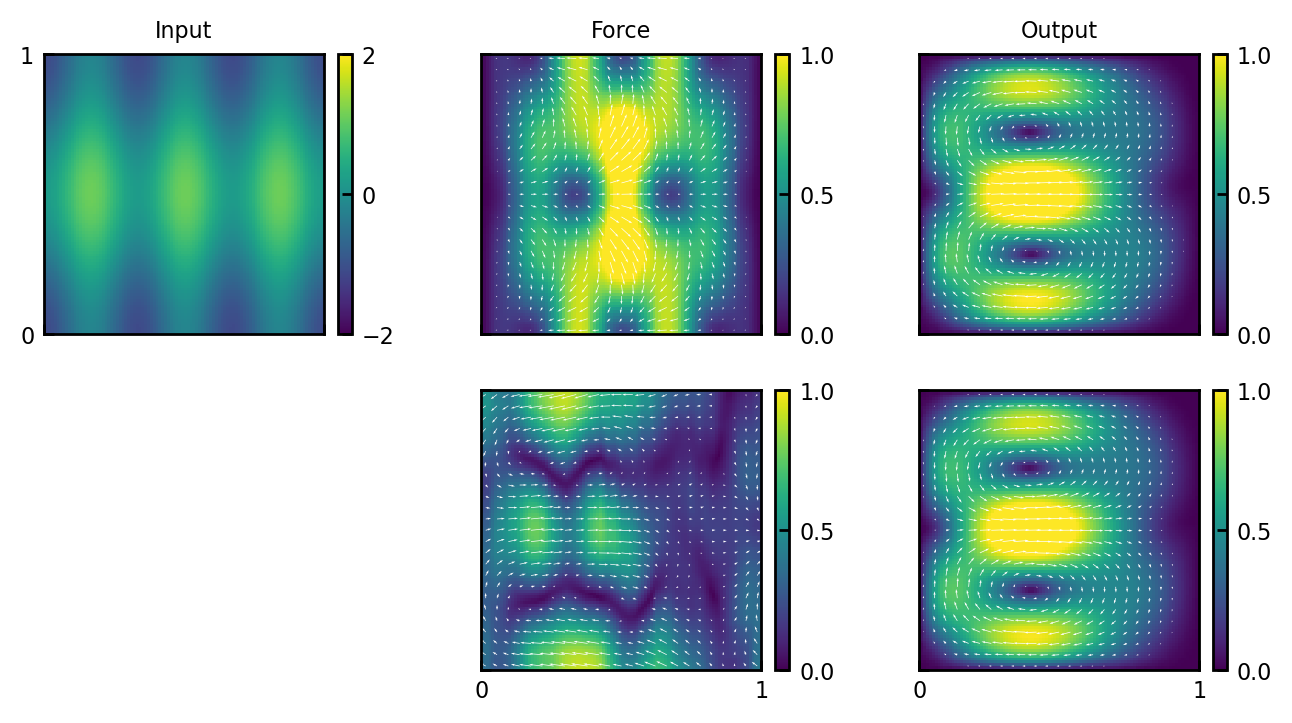

In [33]:
from train_pbnn import get_model, get_dataset
import yaml
from pprint import pprint

import torch

with open('../models/Stokes/TorchLatentNet/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
config['dataset']['reduced_functional'] = True

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

# Generate predictions
with torch.no_grad():
    sample = val[20]
    force = model(torch.FloatTensor(sample['inputs']).to(device))
    force = force.detach().cpu()

    force = multichannel_img_to_dofs(
        force,
        sample['grid_x'], sample['grid_y'],
        sample['function_space'],
        return_function=True,
    )
    pred = val.dataset.build_problem.forward(force)

    print(f'Loss with assigned force: {sample['Jhat'](force.vector()[:]):.3g}')

    inputs = sample['inputs']
    force = force.compute_vertex_values().reshape([2, -1])
    pred = pred.compute_vertex_values().reshape([2, -1])

fig, ax = plt.subplots(2, 3, figsize=(8,4), sharex=True, sharey=True, squeeze=False)

plot_grid(ax[0,0], inputs[2], inputs[0], inputs[1], vmin=-2, vmax=2)

outputs = sample['output']
plot_mesh_vector(ax[0,2], outputs, val.dataset.mesh, vmin=0, vmax=1)

# Generate and plot model predictions
plot_mesh_vector(ax[1,1], force, val.dataset.mesh, vmin=0, vmax=1)
plot_mesh_vector(ax[1,2], pred,  val.dataset.mesh, vmin=0, vmax=1)

f = multichannel_img_to_dofs(
    sample['force'], 
    sample['grid_x'], 
    sample['grid_y'], 
    sample['function_space'],
    return_function=True)
target = val.dataset.build_problem.forward(f)
print(f'Loss with ground truth force: {sample['Jhat'](f.vector()[:]):.3g}')
f = f.compute_vertex_values().reshape([2, -1])
plot_mesh_vector(ax[0,1], f, val.dataset.mesh, vmin=0, vmax=1)
#target = target.compute_vertex_values().reshape([2, -1])
#plot_mesh_vector(ax[0,2], target, val.dataset.mesh, vmin=0, vmax=0.3)


ax[0,0].set_title('Input')
ax[0,1].set_title('Force')
ax[0,2].set_title('Output')

for a in ax.flatten():
    a.set(aspect='equal', xlim=[0,1], ylim=[0,1], xticks=[0,1], yticks=[0,1])

ax[1,0].axis('off')

# Elasticity problem

INFO:train_pbnn:Building a DolfinPBNN
INFO:train_pbnn:Loading model weights from ../models/ElasticityAdhesion/DolfinUNet/model_weight.ckpt
/home/jcolen/physics_ml_toolbox/pbnn/notebooks/../src/train_pbnn.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pl

Loss with assigned force: 0.00147
Loss with ground truth force: 7.39e-06


(0.0, 1.0, 0.0, 1.0)

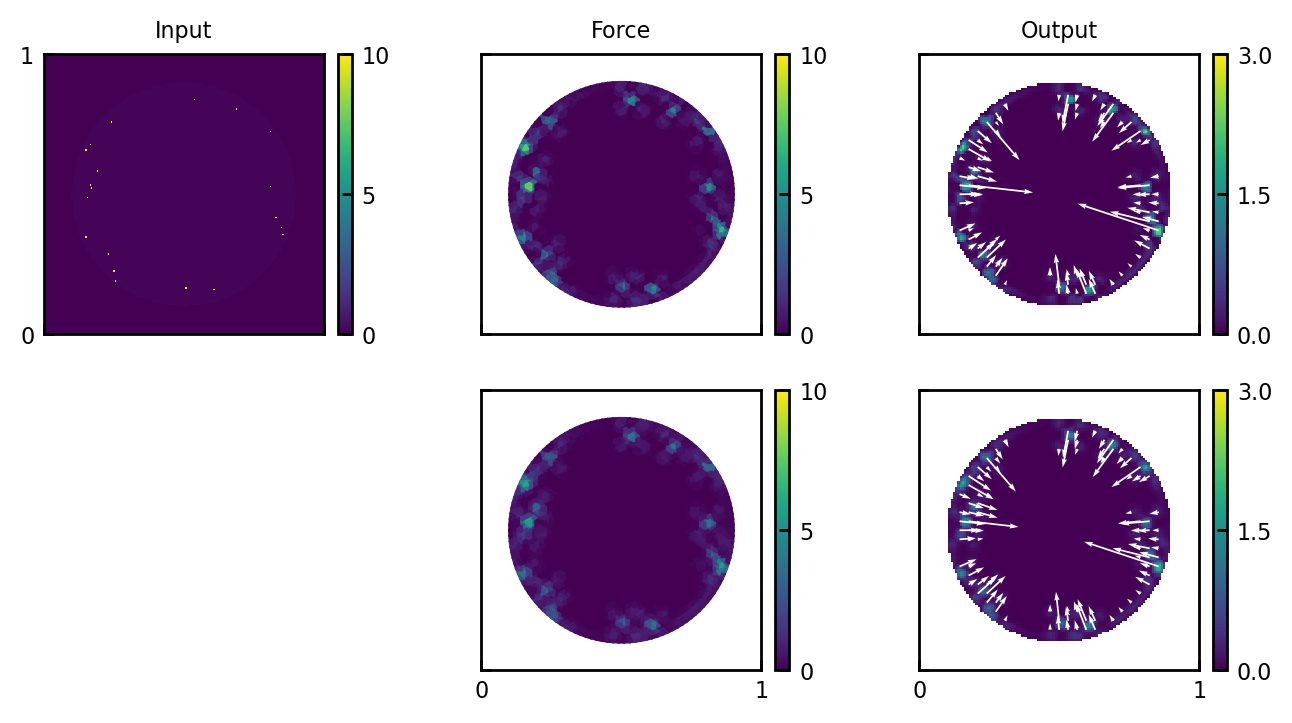

In [21]:
from train_pbnn import get_model, get_dataset
import yaml
from pprint import pprint

import torch

with open('../models/ElasticityAdhesion/DolfinUNet/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

# Generate predictions
with torch.no_grad():
    sample = val[10]
    force = model(torch.FloatTensor(sample['inputs']).to(device))
    force = force.detach().cpu()

    force = multichannel_img_to_dofs(
        force,
        sample['grid_x'], sample['grid_y'],
        sample['function_space'],
        return_function=True,
    )
    pred = val.dataset.build_problem.forward(force)

    print(f'Loss with assigned force: {sample['Jhat'](force.vector()[:]):.3g}')

    inputs = sample['inputs']
    force = force.compute_vertex_values()
    pred = pred.compute_vertex_values().reshape([2, -1])
    outputs = sample['output']

fig, ax = plt.subplots(2, 3, figsize=(8,4), sharex=True, sharey=True, squeeze=False)

plot_grid(ax[0,0], inputs[2], inputs[0], inputs[1], vmin=0, vmax=10)
plot_mesh_vector(ax[0,2], outputs, val.dataset.mesh, vmin=0, vmax=3)

# Generate and plot model predictions
plot_mesh(ax[1,1], force, val.dataset.mesh, vmin=0, vmax=10)
plot_mesh_vector(ax[1,2], force * pred,  val.dataset.mesh, vmin=0, vmax=3)


f = multichannel_img_to_dofs(
    sample['force'], 
    sample['grid_x'], 
    sample['grid_y'], 
    sample['function_space'],
    return_function=True)
print(f'Loss with ground truth force: {sample['Jhat'](f.vector()[:]):.3g}')
f = f.compute_vertex_values()
plot_mesh(ax[0,1], f, val.dataset.mesh, vmin=0, vmax=10)

ax[0,0].set_title('Input')
ax[0,1].set_title('Force')
ax[0,2].set_title('Output')

for a in ax.flatten():
    a.set(aspect='equal', xlim=[0,1], ylim=[0,1], xticks=[0,1], yticks=[0,1])

ax[1,0].axis('off')